In [31]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [32]:
df = pd.read_csv('./data/data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [34]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [35]:
df.rename(columns={'conversion':'target', 'offer':'treatment'}, inplace=True)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [36]:
df['treatment'].replace({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1}, inplace=True)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [37]:
cat_features = ['zip_code', 'channel']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], random_state=42, train_size=0.7)

In [39]:
treat_train = X_train['treatment']
X_train.drop(columns='treatment', inplace=True)
treat_val = X_test['treatment']
X_test.drop(columns='treatment', inplace=True)

In [40]:
metrics_df = pd.DataFrame(columns=['model', 'uplift@10%', 'uplift@20%'])
metrics_df

,model,uplift@10%,uplift@20%


array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

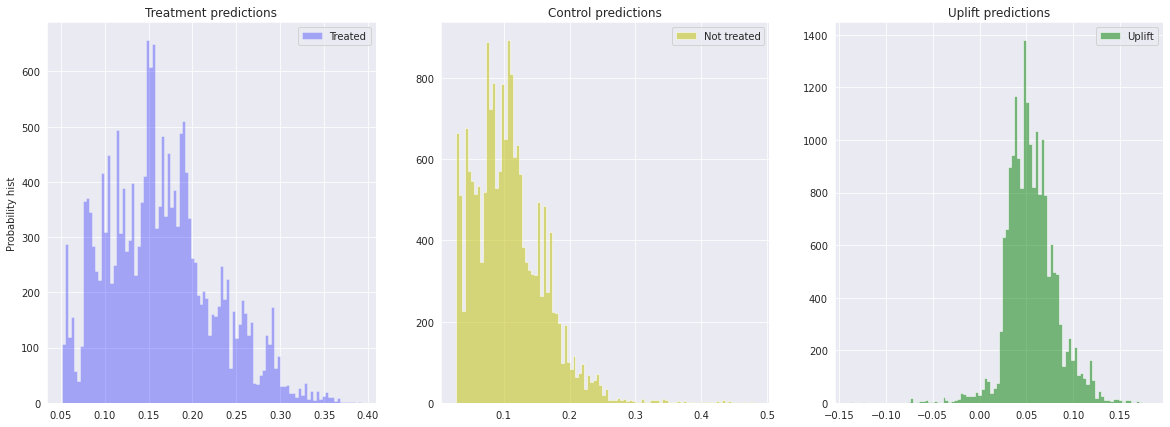

In [41]:
sm = SoloModel(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features))
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_test, uplift_sm, treat_val, 'by_group', 0.1)
sm_score_20 = uplift_at_k(y_test, uplift_sm, treat_val, 'by_group', 0.2)

metrics_df = metrics_df.append({'model': type(sm).__name__,
              'uplift@10%': sm_score_10,
              'uplift@20%': sm_score_20}, ignore_index=True)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(sm_trmnt_preds, sm_ctrl_preds)

In [42]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
                            'model': type(ct).__name__,
                            'uplift@10%': ct_score_10,
                            'uplift@20%': ct_score_20}, ignore_index=True)

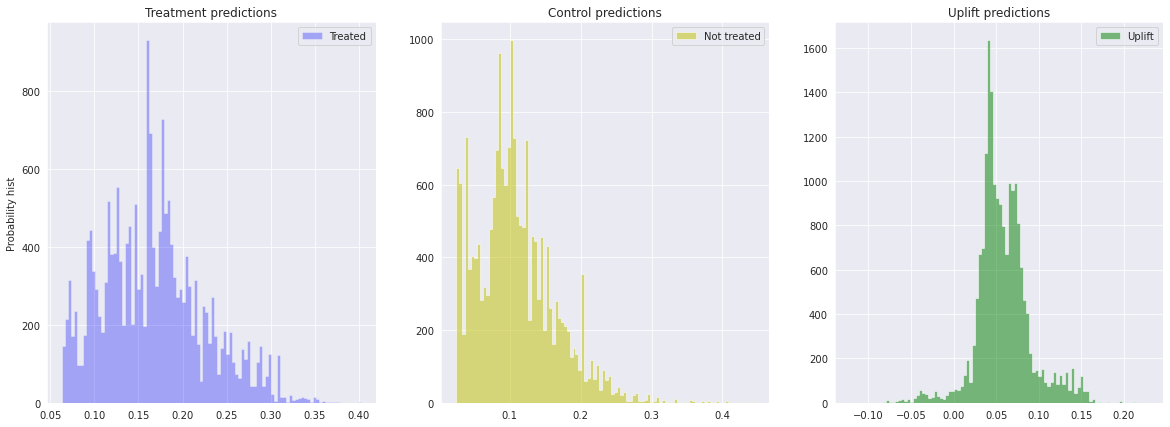

In [43]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(tm).__name__,
    'uplift@10%': tm_score_10,
    'uplift@20%': tm_score_20
}, ignore_index=True)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [44]:
metrics_df

,model,uplift@10%,uplift@20%
0,SoloModel,0.122913,0.100633
1,ClassTransformation,0.119108,0.103868
2,TwoModels,0.109515,0.091545


In [45]:
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test)

In [46]:
df_test = X_test.copy()
df_test['pred_uplift'] = uplift_sm
df_test['conversion'] = y_test
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion
33042,9,64.85,1,0,Surburban,1,Web,0.032169,0
7209,1,144.12,0,1,Urban,0,Web,0.084523,0
24367,1,734.25,0,1,Surburban,1,Phone,0.066616,0
19599,4,1321.26,1,0,Surburban,1,Multichannel,0.058384,1
31465,2,261.23,1,1,Surburban,1,Web,0.169083,1


In [47]:
df_test = df_test.sort_values(by='pred_uplift', ascending=False)
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion
46363,12,206.35,1,1,Surburban,0,Phone,0.180251,1
16356,2,236.10,1,1,Urban,1,Web,0.172420,0
49746,2,223.52,1,1,Surburban,1,Web,0.172420,0
34504,3,237.01,1,1,Urban,1,Web,0.171937,1
57763,3,243.20,1,1,Surburban,1,Web,0.171937,0


In [48]:
df_test['deciles'] = pd.qcut(df_test['pred_uplift'], q=10, labels=False)
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion,deciles
46363,12,206.35,1,1,Surburban,0,Phone,0.180251,1,9
16356,2,236.10,1,1,Urban,1,Web,0.172420,0,9
49746,2,223.52,1,1,Surburban,1,Web,0.172420,0,9
34504,3,237.01,1,1,Urban,1,Web,0.171937,1,9
57763,3,243.20,1,1,Surburban,1,Web,0.171937,0,9


In [49]:
for i in range(0, 10):
    tmp = df_test[df_test['deciles'] == i]
    print(f'Для дециля {i} средняя конверсия равна {tmp["conversion"].mean():.3f}')

Для дециля 0 средняя конверсия равна 0.133
Для дециля 1 средняя конверсия равна 0.106
Для дециля 2 средняя конверсия равна 0.127
Для дециля 3 средняя конверсия равна 0.135
Для дециля 4 средняя конверсия равна 0.126
Для дециля 5 средняя конверсия равна 0.145
Для дециля 6 средняя конверсия равна 0.153
Для дециля 7 средняя конверсия равна 0.154
Для дециля 8 средняя конверсия равна 0.165
Для дециля 9 средняя конверсия равна 0.220
